In [5]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf

import warnings

# Suppress specific warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
#warnings.simplefilter(action='ignore', category=ValueWarning)

## 0. Download Data

In [41]:
df = web.DataReader('NVDA', 'stooq')
print(df.head())

               Open    High     Low   Close       Volume
Date                                                    
2025-02-14  136.480  139.25  135.50  138.85  195479557.0
2025-02-13  131.555  136.50  131.17  135.29  197429975.0
2025-02-12  130.020  132.24  129.08  131.14  160278552.0
2025-02-11  132.580  134.48  131.02  132.80  178902379.0
2025-02-10  130.090  135.00  129.96  133.57  216989086.0


## 1. Load Data & Preprocess

In [45]:
df = df.sort_index(ascending=True)

# Filter last n years of data
df = df[df.index >= df.index.max() - pd.DateOffset(years=2)]

# Extract today's price
today = df.index[-1]
today_close_price = round(df['Close'].iloc[-1], 2)

print(f"Today's Date: {today}")
print(f"Today's Closing Price: ${today_close_price:.2f}")


Today's Date: 2025-02-14 00:00:00
Today's Closing Price: $138.85


In [47]:
print(f"Dataset Min Date: {df.index.min()}, Max Date: {df.index.max()}")
print(f"Total Rows: {len(df)}")

Dataset Min Date: 2023-02-14 00:00:00, Max Date: 2025-02-14 00:00:00
Total Rows: 503


## 1.2 Calculate Technical Indicators

In [53]:
# 1. Simple Moving Average (SMA)
df['SMA_14'] = df['Close'].rolling(window=14).mean()

# 2. Exponential Moving Average (EMA)
df['EMA_14'] = df['Close'].ewm(span=14, adjust=False).mean()

# 3. MACD (Moving Average Convergence Divergence)
short_window = 12
long_window = 26
signal_window = 9

df['MACD'] = df['Close'].ewm(span=short_window, adjust=False).mean() - df['Close'].ewm(span=long_window, adjust=False).mean()
df['MACD_Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

# 4. Relative Strength Index (RSI)
window_length = 14

delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()

rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 5. Bollinger Bands (20-day moving average with 2 standard deviations)
rolling_mean = df['Close'].rolling(window=20).mean()
rolling_std = df['Close'].rolling(window=20).std()

df['Upper_BB'] = rolling_mean + (rolling_std * 2)
df['Lower_BB'] = rolling_mean - (rolling_std * 2)

# 6. Average True Range (ATR)
df['TR'] = np.maximum(df['High'] - df['Low'], 
                      np.maximum(abs(df['High'] - df['Close'].shift(1)), 
                                 abs(df['Low'] - df['Close'].shift(1))))
df['ATR_14'] = df['TR'].rolling(window=14).mean()

# Drop NaN values caused by rolling calculations
df.dropna(inplace=True)

features = ['SMA_14', 'EMA_14', 'MACD', 'MACD_Signal', 'RSI_14', 'Upper_BB', 'Lower_BB', 'ATR_14', 'Volume']
target_column = 'Close'


## 2. Check for Stationarity (ADF Test) & Apply Differencing if Needed

In [ ]:
# ✅ Preserve original dataset before modifications
df_original = df.copy()

# ADF Test Function
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1]  # p-value

p_value = adf_test(df['Close'])
differenced = False
target_column = 'Close'

if p_value > 0.05:
    df['Close_diff'] = df['Close'].diff()
    df['Close_Adj'] = df['Close']  # ✅ Store original Close for later use
    df.dropna(inplace=True)  # Drops first row (NaN from differencing)
    target_column = 'Close_diff'
    differenced = True
else:
    df['Close_Adj'] = df['Close']  # ✅ If no differencing, keep Close as Close_Adj

# Select relevant features

data_to_use = df[[target_column, 'Close_Adj'] + features].dropna()  # ✅ Always keep Close_Adj


## 3. Auto-Detect Seasonality

In [55]:
def detect_seasonality(series, max_lag=30):
    acf_values = acf(series, nlags=max_lag, fft=True)

    # Find the first peak in ACF that is significant
    for lag in range(1, max_lag):
        if acf_values[lag] > 0.2:  # Threshold for significance
            return lag  # Return detected seasonality period
    
    return 7  # Default to weekly seasonality if no clear peak is found


## 4. BackTesting

In [ ]:
def backtest_sarimax(df, method='sliding'):

    backtest_results = []
    total_wins = 0
    total_predictions = 0
    total_rmse = 0
    num_periods = 0  # Track number of backtest periods

    df = df.sort_index(ascending=True)
    start_idx = 365  # Start with 1-year training data
    total_data_points = len(df)

    for i in range(start_idx, total_data_points - 30, 30):  
        train_data = df.iloc[i - 365:i] if method == 'sliding' else df.iloc[:i]
        test_data = df.iloc[i:i + 30]

        exog_train = train_data.drop(columns=[target_column, 'Close_Adj'], errors='ignore')
        exog_test = test_data.drop(columns=[target_column, 'Close_Adj'], errors='ignore')

        if exog_train.shape[1] == 0:
            exog_train, exog_test = None, None

        # ✅ Dynamically detect `m`
        detected_m = detect_seasonality(train_data[target_column], max_lag=30)
        
        # AutoARIMA for optimal SARIMAX order
        auto_arima_model = auto_arima(
            train_data[target_column], 
            seasonal=True, 
            m=detected_m, 
            error_action='ignore', 
            suppress_warnings=True
        )
        order, seasonal_order = auto_arima_model.order, auto_arima_model.seasonal_order

        # Train SARIMAX
        model = SARIMAX(train_data[target_column], order=order, seasonal_order=seasonal_order, exog=exog_train)
        model_fit = model.fit(disp=False)

        forecast = model_fit.get_forecast(steps=30, exog=exog_test).predicted_mean

        # ✅ Dynamically reverse differencing using Close_Adj
        if differenced:
            forecast = df['Close_Adj'].iloc[i - 1] + np.cumsum(forecast)

        # Compute RMSE
        rmse = np.sqrt(mean_squared_error(test_data[target_column], forecast))
        total_rmse += rmse  # Accumulate RMSE values
        num_periods += 1  # Increment period counter

        # actual and predicted
        actual_movement = test_data[target_column].values - df['Close_Adj'].iloc[i - 1]
        predicted_movement = forecast.values - df['Close_Adj'].iloc[i - 1]

        # Count wins where predicted and actual move in the same direction
        wins = np.sum(np.sign(actual_movement) == np.sign(predicted_movement))
        total_wins += wins
        total_predictions += len(test_data)

        # Store backtest results
        backtest_results.append({
            'Start Date': df.index[i],
            'End Date': df.index[i + 29],
            'RMSE': rmse,
            'Wins': wins,
            'Total Predictions': len(test_data),
            'Win Rate (%)': (wins / len(test_data)) * 100
        })
    print(f"Start Index: {start_idx}, Total Data Points: {total_data_points}")
    print(f"Expected Iterations: {(total_data_points - start_idx) // 30}")

    # Calculate final metrics
    overall_win_rate = (total_wins / total_predictions) * 100 if total_predictions > 0 else 0
    avg_rmse = total_rmse / num_periods if num_periods > 0 else 0

    # Convert to DataFrame and display
    results_df = pd.DataFrame(backtest_results)

    # Append final summary row
    summary_row = {
        'Start Date': 'Overall',
        'End Date': 'Summary',
        'RMSE': avg_rmse,
        'Wins': total_wins,
        'Total Predictions': total_predictions,
        'Win Rate (%)': overall_win_rate
    }
    results_df = pd.concat([results_df, pd.DataFrame([summary_row])], ignore_index=True)

    # Print Summary
    #print(f"\nFinal Summary for {method.capitalize()} Window:")
    #print(f"✅ Average RMSE: {avg_rmse:.4f}")
    #print(f"✅ Overall Win Rate: {overall_win_rate:.2f}%")

    return results_df, overall_win_rate, avg_rmse


In [ ]:
sliding_results, sliding_win_rate, sliding_avg_rmse = backtest_sarimax(data_to_use, method='sliding')
expanding_results, expanding_win_rate, expanding_avg_rmse = backtest_sarimax(data_to_use, method='expanding')

In [ ]:
print(sliding_results.shape)
print(expanding_results.shape)
print(sliding_win_rate)
print(expanding_win_rate)
print(sliding_avg_rmse)
print(expanding_avg_rmse)

## 5. Find Best ARIMA Parameters Using Auto ARIMA

In [65]:
# ✅ Get today's date dynamically
today = df.index.max()  # Last available date in the dataset
one_year_ago = today - pd.DateOffset(years=1)  # Get data exactly 1 year before today

# ✅ Filter last 1 year of data
train_data = df[df.index >= one_year_ago]

# ✅ Define exogenous variables (always present)
exog_train = train_data.drop(columns=[target_column, 'Close'], errors='ignore')

# ✅ Get exact 30 most recent trading days for seasonality detection
trading_days = df.loc[df.index >= today - pd.DateOffset(days=60)]  # Ensure at least 30 valid days
recent_30_days = trading_days.iloc[-30:]  # ✅ Last 30 trading days

# ✅ Detect seasonality (`m`) dynamically from the last 30 trading days
detected_m = detect_seasonality(recent_30_days[target_column], max_lag=30)

# ✅ Use AutoARIMA to find the best SARIMA order
auto_arima_model = auto_arima(
    train_data[target_column], 
    seasonal=True, 
    m=1,  
    error_action='ignore', 
    suppress_warnings=True
)
order, seasonal_order = auto_arima_model.order, auto_arima_model.seasonal_order

## 5. Train SARIMA Model

In [67]:
# Fit SARIMAX Model with Exogenous Variables
sarimax_model = SARIMAX(
    train_data[target_column], 
    order=order, 
    seasonal_order=seasonal_order, 
    exog=exog_train
)

sarimax_fit = sarimax_model.fit(disp=False)

## 6. Generate 30-Day Forecast

In [87]:
# ✅ Generate proper date index for the 30-day forecast
forecast_start_date = today + pd.DateOffset(days=1)  # Start from the next day after today
forecast_dates = pd.date_range(start=forecast_start_date, periods=30, freq='B')  # 'B' ensures business days

# ✅ Generate 30-Day Forecast using the latest exogenous variables
future_exog = df.iloc[-30:, :].drop(columns=[target_column, 'Close_Adj'], errors='ignore')  # Last 30 rows of exogenous data
future_forecast = sarimax_fit.get_forecast(steps=30, exog=future_exog)
future_forecast_mean = future_forecast.predicted_mean

# ✅ Assign forecasted dates as index
future_forecast_mean.index = forecast_dates
"""
# ✅ Reverse Differencing (if applied)
if differenced:
    future_forecast_mean = df['Close_Adj'].iloc[-1] + np.cumsum(future_forecast_mean)
"""
# ✅ Get forecasted price 30 days from today
forecasted_price_30_days = future_forecast_mean.iloc[-1]

# ✅ Calculate price change percentage
price_change_percentage = ((forecasted_price_30_days - today_close_price) / today_close_price) * 100

# ✅ Generate buy/sell/hold recommendation
recommendation = 'Buy' if price_change_percentage > 5 else 'Sell' if price_change_percentage < -5 else 'Hold'

# ✅ Print forecast summary
print(f"📌 Forecast Summary:")
print(f"Today's Closing Price: ${today_close_price:.2f}")
print(f"Forecasted Price in 30 Days: ${forecasted_price_30_days:.2f}")
print(f"Expected Change: {price_change_percentage:.2f}%")
print(f"Investment Recommendation: {recommendation}")


📌 Forecast Summary:
Today's Closing Price: $138.85
Forecasted Price in 30 Days: $138.85
Expected Change: -0.00%
Investment Recommendation: Hold


## 7. Investment Recommendation

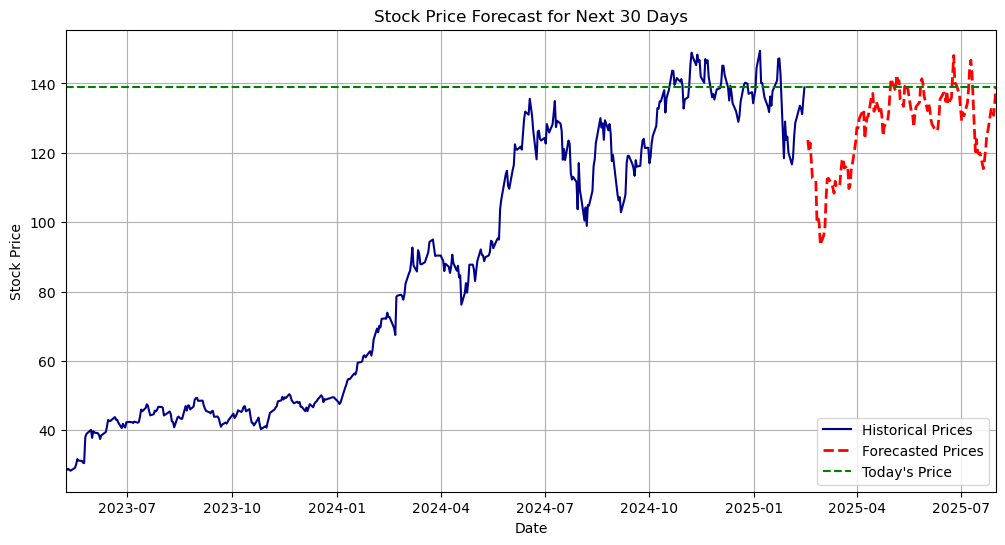

,Description,Value
0,Today's Date,2025-02-14
1,Today's Closing Price,$138.85
2,Forecasted Date,2025-08-01
3,Forecasted Price in 30 Days,$138.85
4,Price Change Percentage,-0.0%
5,Investment Recommendation,Hold


In [85]:
# Get the earliest available date in df
earliest_date = df.index[0]  # First observation in df

# Get the last forecasted date
last_forecast_date = future_forecast_mean.index[-1]  # Last observation in forecast


# Set x-axis limits dynamically (earliest date to last forecasted date)
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Historical Prices', color='darkblue')
plt.plot(future_forecast_mean.index, future_forecast_mean, label='Forecasted Prices', color='red', linewidth=2, linestyle='dashed')
plt.axhline(y=today_close_price, color='green', linestyle='--', label="Today's Price")

# Dynamically set x-axis limits from earliest date in df to forecasted date
plt.xlim(earliest_date, last_forecast_date)  # Corrected x-axis scaling

plt.legend()
plt.title("Stock Price Forecast for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()

# Define today's date and 30-day forecasted date
forecast_end_date = forecast_dates[-1]  # Last date in the forecast

# Create a structured dictionary for dynamic data presentation with the correct order
summary_data = {
    "Description": [
        "Today's Date", 
        "Today's Closing Price", 
        "Forecasted Date", 
        "Forecasted Price in 30 Days", 
        "Price Change Percentage", 
        "Investment Recommendation"
    ],
    "Value": [
        today.strftime('%Y-%m-%d'),  # Dynamic today's date
        f"${round(today_close_price, 3)}",  # Rounded today's price
        forecast_dates[-1].strftime('%Y-%m-%d'),  # Dynamic forecasted date
        f"${round(forecasted_price_30_days, 3)}",  # Rounded forecasted price
        f"{round(price_change_percentage, 3)}%",  # Rounded percentage change
        recommendation  # Dynamic recommendation
    ]
}

# Convert to DataFrame for display
summary_df = pd.DataFrame(summary_data)
summary_df